In [1]:
# =====================================================
#     Tên: Real Estate Price Prediction
#     Nghiên cứu khoa học: "Nghiên cứu tối ưu mô hình kết hợp
#     trong việc dự đoán giá nhà tại Hà Nội"
#     Mô hình sử dụng: Linear Regression & Random Forest
# =====================================================

In [2]:
# -------------------------------------------------
# 0. CÀI THƯ VIỆN (Colab cài mới nhất đã hỗ trợ GPU)
# -------------------------------------------------
!pip install -U xgboost optuna --quiet pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 85.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
# -------------------------------------------------
# 1. IMPORT & ĐỌC DỮ LIỆU
# -------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# --- tải/đọc CSV ---
DATA_PATH = Path("data_processing.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Không tìm thấy file: {DATA_PATH}")
data = pd.read_csv(DATA_PATH)

target = "price"
y = data[target]
X = data.drop(columns=[target])

In [4]:
# -------------------------------------------------
# 2. TIỀN XỬ LÝ: ColumnTransformer + Pipeline
# -------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_cols  = X.select_dtypes(include=["int64", "float64"]).columns
bool_cols = X.select_dtypes(include=["bool"]).columns  # 1‑hot district

preprocess = ColumnTransformer([
    ("num",  StandardScaler(),   num_cols),
    ("bool", "passthrough",      bool_cols)  # giữ nguyên 0/1
])

In [5]:
# -------------------------------------------------
# 3. ĐỊNH NGHĨA RMSLE & SCORER
# -------------------------------------------------
from sklearn.metrics import make_scorer, mean_squared_log_error

def rmsle(y_true, y_pred):
    # Cắt giá trị về >= 0 để tránh log(âm)
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Tạo scorer cho cross_val_score,
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [6]:
# -------------------------------------------------
# 4. TÁCH TRAIN / TEST (80 % / 20 %)
# -------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# -------------------------------------------------
# 5. OPTUNA: TUNE RANDOM FOREST (CPU)
# -------------------------------------------------
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):

    params = {
        "n_estimators"      : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"         : trial.suggest_int("max_depth", 4, 30),
        "max_features"      : trial.suggest_float("max_features", 0.3, 1.0),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf"  : trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap"         : trial.suggest_categorical("bootstrap", [True, False]),
        "random_state"      : 42,
        "n_jobs"            : -1                # đa luồng CPU
    }

    model = Pipeline([
        ("prep", preprocess),                   # scaler + one‑hot
        ("rf",   RandomForestRegressor(**params))
    ])

    # 5‑fold CV – Optuna sẽ MINIMIZE RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-13 04:34:56,118] A new study created in memory with name: no-name-2e0a53bd-9570-4159-a04a-bce31050efcb


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-13 04:35:22,388] Trial 0 finished with value: 0.5693969646299653 and parameters: {'n_estimators': 776, 'max_depth': 5, 'max_features': 0.3271522390863593, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.5693969646299653.
[I 2025-05-13 04:38:13,802] Trial 1 finished with value: 0.25272218913701466 and parameters: {'n_estimators': 1157, 'max_depth': 18, 'max_features': 0.4008083845177811, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 1 with value: 0.25272218913701466.
[I 2025-05-13 04:40:11,576] Trial 2 finished with value: 0.2378514735553289 and parameters: {'n_estimators': 526, 'max_depth': 28, 'max_features': 0.5560671830500981, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 2 with value: 0.2378514735553289.
[I 2025-05-13 04:41:16,744] Trial 3 finished with value: 0.40352977762478925 and parameters: {'n_estimators': 954, 'max_depth': 9, 'max_features': 0.3

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-05-13 04:46:57,233] Trial 5 finished with value: 0.2540627255497988 and parameters: {'n_estimators': 1467, 'max_depth': 16, 'max_features': 0.5296017351964464, 'min_samples_split': 8, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 2 with value: 0.2378514735553289.
[I 2025-05-13 04:48:14,155] Trial 6 finished with value: 0.36897228594187814 and parameters: {'n_estimators': 1011, 'max_depth': 8, 'max_features': 0.6028648160058172, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 2 with value: 0.2378514735553289.
[I 2025-05-13 04:48:56,986] Trial 7 finished with value: 0.2601096730440193 and parameters: {'n_estimators': 364, 'max_depth': 19, 'max_features': 0.48858064869427487, 'min_samples_split': 10, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 2 with value: 0.2378514735553289.
[I 2025-05-13 04:54:12,221] Trial 8 finished with value: 0.228562230468747 and parameters: {'n_estimators': 1130, 'max_depth': 26, 'max_features': 0.

In [8]:
# -------------------------------------------------
# 6. HUẤN LUYỆN MÔ HÌNH TỐI ƯU & SO SÁNH VỚI LINEAR REG
# -------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 6.1 Rf Pipeline với tham số tốt nhất
rf_model = Pipeline([
    ("prep", preprocess),
    ("rf",  RandomForestRegressor(**study.best_params))
]).fit(X_train, y_train)

# 6.2 Linear Regression (có scaler sẵn trong preprocess)
lr_model = Pipeline([
    ("prep", preprocess),
    ("lr",   LinearRegression())
]).fit(X_train, y_train)

# 6.3 Dự báo & đánh giá
def evaluate(name, y_true, y_pred, k):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((len(y_true) - 1)/(len(y_true) - k - 1))
    print(f"\n{name}")
    print("-"*30)
    print(f"RMSE : {rmse:,.3f}")
    print(f"RMSLE: {rmsle(y_true, y_pred):.3f}")
    print(f"R²   : {r2:.4f} | Adj‑R²: {adj_r2:.4f}")

rf_pred = rf_model.predict(X_test)
lr_pred  = lr_model.predict(X_test)

k_features = X_train.shape[1]
evaluate("Random Forest CPU", y_test, rf_pred, k=k_features)
evaluate("Linear Regression", y_test, lr_pred, k=k_features)


Random Forest CPU
------------------------------
RMSE : 21.172
RMSLE: 0.178
R²   : 0.8115 | Adj‑R²: 0.8104

Linear Regression
------------------------------
RMSE : 37.237
RMSLE: 0.879
R²   : 0.4168 | Adj‑R²: 0.4135


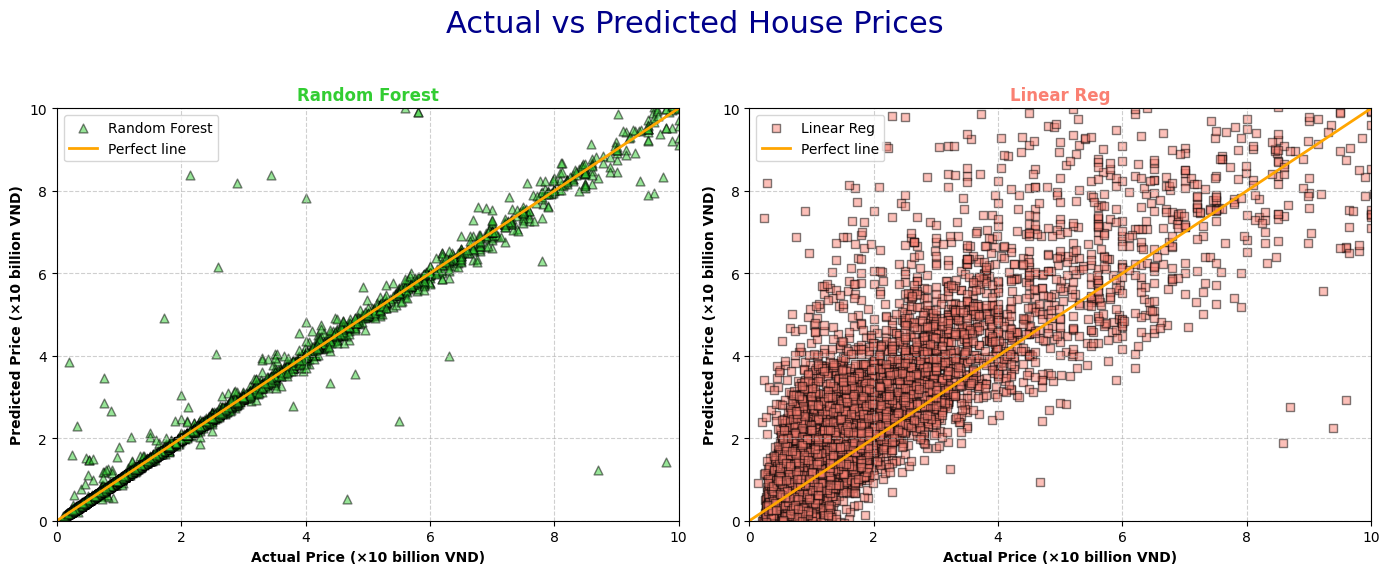

In [9]:
# -------------------------------------------------
# 7. MINH HỌA SCATTER ACTUAL vs PREDICTED
# -------------------------------------------------
import matplotlib.pyplot as plt

models = [("Random Forest", rf_pred, "limegreen",   "^"),
          ("Linear Reg", lr_pred, "salmon", "s")]

plt.figure(figsize=(14,6))
for i, (name, pred, color, marker) in enumerate(models, 1):
    plt.subplot(1,2,i)
    plt.scatter(y_test/10, pred/10, c=color, marker=marker,
                s=40, edgecolors="black", alpha=0.5, label=name)
    plt.plot([0,10], [0,10], "orange", lw=2, label="Perfect line")
    plt.xlim(0,10); plt.ylim(0,10)
    plt.xlabel("Actual Price (×10 billion VND)", fontweight="bold")
    plt.ylabel("Predicted Price (×10 billion VND)", fontweight="bold")
    plt.title(name, fontweight="bold", color=color)
    plt.grid(ls="--", alpha=0.6); plt.legend()

plt.suptitle("Actual vs Predicted House Prices", fontsize=22, color="darkblue")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

In [10]:
# -------------------------------------------------
# 8. IMPORT THƯ VIỆN
# -------------------------------------------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
import numpy as np

In [11]:
# -------------------------------------------------
# 9. BASE MODEL (đều bọc trong pipeline có 'prep')
# -------------------------------------------------
rf_pipe = Pipeline([
        ("prep", preprocess),
        ("rf",  RandomForestRegressor(**study.best_params))
])

lin_pipe = Pipeline([
        ("prep", preprocess),
        ("lr",   LinearRegression())
])

In [12]:
# -------------------------------------------------
# 10. META‑MODEL  (RidgeCV cho chắc chắn)
# -------------------------------------------------
meta_model = RidgeCV(alphas=np.logspace(-3,3,13))

In [13]:
# -------------------------------------------------
# 11. STACKING REGRESSION  (K=10 fold, shuffle)
# -------------------------------------------------
stack = StackingRegressor(
        estimators=[('rf', rf_pipe),
                    ('lin', lin_pipe)],
        final_estimator=meta_model,
        cv=KFold(n_splits=10, shuffle=True, random_state=42),
        n_jobs=-1,
        passthrough=False    # chỉ dùng dự báo base model
)

In [14]:
# -------------------------------------------------
# 12. HUẤN LUYỆN
# -------------------------------------------------
stack.fit(X_train, y_train)


StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('rf',
                               Pipeline(steps=[('prep',
                                                ColumnTransformer(transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 Index(['price_per_m2', 'area', 'floors', 'toilets', 'bedrooms', 'balcony',
       'street_frontage', 'legal', 'interior', 'year', 'month', 'day'],
      dtype='object')),
                                                                                ('bool',
                                                                                 'passthrough',
                                                                                 Index(['house_ty...
       'district_ThanhTri', 'district_ThanhXuan', 'district_ThuongTin',
       'district_UngHoa'],
      dtype='object'))])),
                                               ('lr', LinearRegression())]))],
                  final_estimator=RidgeCV(alphas=array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])),
                  n_jobs=-1)

In [15]:
# -------------------------------------------------
# 13. ĐÁNH GIÁ DỰA TRÊN TẬP TEST
# -------------------------------------------------
pred_test = stack.predict(X_test)

rmse  = np.sqrt(mean_squared_error(y_test, pred_test))
rmsle = np.sqrt(mean_squared_log_error(
                    np.clip(y_test, 0, None)+1,
                    np.clip(pred_test, 0, None)+1))
r2    = r2_score(y_test, pred_test)

print(f"RMSE  : {rmse:,.3f}")
print(f"RMSLE : {rmsle:.3f}")
print(f"R²    : {r2:.4f}")

RMSE  : 20.391
RMSLE : 0.245
R²    : 0.8251


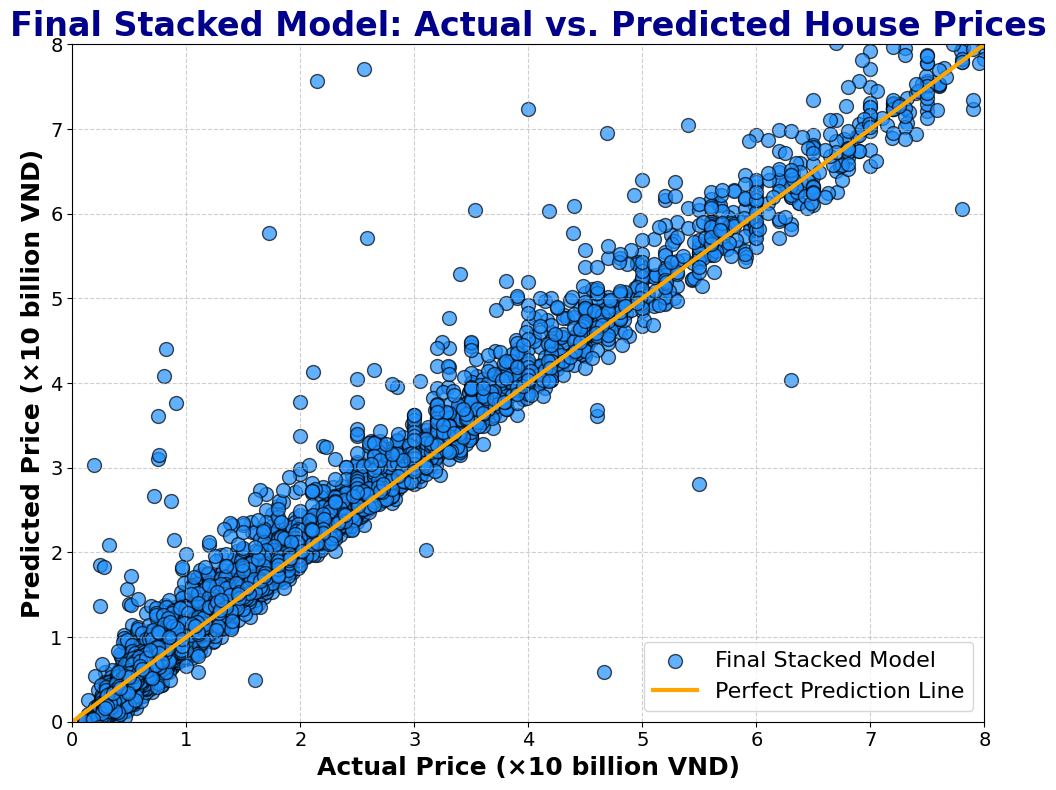

In [16]:
# -------------------------------------------------
# 14. VẼ SCATTER
# -------------------------------------------------
plt.figure(figsize=(10, 8))
plt.title("Final Stacked Model: Actual vs. Predicted House Prices", fontsize=24, fontweight='bold', color='darkblue')

plt.scatter(y_test / 10, pred_test / 10,
            color='dodgerblue', marker='o', edgecolors="black", alpha=0.7, s=100, label="Final Stacked Model")

plt.plot([0, 8], [0, 8], "orange", lw=3, label="Perfect Prediction Line")

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.xlabel("Actual Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.ylabel("Predicted Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
import joblib

MODEL_PATH = "Stack_model_Rf+Lr.joblib"

# Lưu toàn bộ pipeline/mô hình
joblib.dump(stack, MODEL_PATH, compress=3)

print("Saved model: Stack_model_Rf+Lr.joblib")

Saved model: Stack_model_Rf+Lr.joblib


In [18]:
# -------------------------------------------------
# 15. TRIỂN KHAI
# -------------------------------------------------
deploy_pred = stack.predict(X_test)
pd.DataFrame({"Price": deploy_pred}) \
  .to_csv("Submission_Stack_(Rf+Lr).csv", index=False)

print("Saved file: Submission_Stack_(Rf+Lr).csv")

Saved file: Submission_Stack_(Rf+Lr).csv
